# Landreman and Paul QA configuration - finding a good set of modular coils

* QA configuration
* 5-field period
* Aspect ratio is 10
* Mean iota is 1.19

In [2]:
from simsopt.mhd import Vmec
from simsopt.geo import SurfaceRZFourier, CurveHelical
import matplotlib.pyplot as plt
from simsopt.objectives import Weight
import numpy as np 
%matplotlib widget

In [19]:
#v = Vmec('input.landreman_paul_qa_scaled')
v = Vmec('input.LandremanPaul2021_QA')
nfp = v.boundary.nfp
surf = v.boundary

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  SEQ =    1 TIME SLICE  0.0000E+00
  PROCESSING INPUT.LandremanPaul2021_QA
  THIS IS PARVMEC (PARALLEL VMEC), VERSION 9.0
  Lambda: Full Radial Mesh. L-Force: hybrid full/half.

  COMPUTER: arm64-apple-darwin20.0.0   OS:    RELEASE:   DATE = Mar 28,2024  TIME = 13:27:37


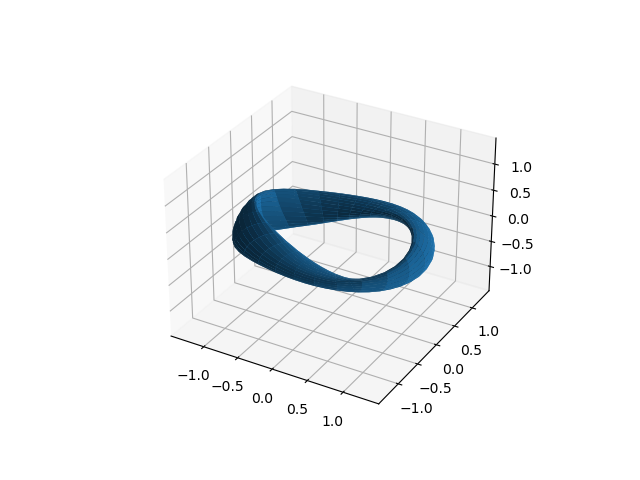

<Axes3D: >

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf.plot(ax=ax, close=True)

In [21]:
from simsopt.geo import CurveLength, CurveCurveDistance, MeanSquaredCurvature, LpCurveCurvature
from simsopt.geo import curves_to_vtk, create_equally_spaced_curves, CurveSurfaceDistance, ToroidalFlux
from simsopt.field.coil import apply_symmetries_to_currents, apply_symmetries_to_curves, ScaledCurrent
from simsopt.objectives import SquaredFlux, QuadraticPenalty
from simsopt.field import BiotSavart, Current
from simsopt.field.coil import Coil
from simsopt.util import MpiPartition
from scipy.optimize import minimize
from simsopt._core.optimizable import Optimizable

In [8]:
CC_dist = 0.08 # based on 83cm winding pack size + 20% margin
wcc = Weight(1E-4)
CS_dist = 0.12 # based on blanket, structure, vessel, LT shield, gaps
wcs = Weight(1E-4)
Length = 2.6 * ncoils # Educated guess based on minor radius of the plasma boundary
wl = Weight(1E-4)
kmax = 5.
wk = Weight(1E-4)


ncoils = 6
order = 7

# max curvature?
# mean curvature?
# max current?

In [9]:
base_curves = create_equally_spaced_curves( ncoils, nfp, True, R0=v.boundary.major_radius(), R1=v.boundary.minor_radius()*3, order=order )
full_curves = apply_symmetries_to_curves( base_curves, nfp, True )

base_currents = [Current(1) for c in base_curves]
full_currents = [ScaledCurrent(c, 1e5) for c in apply_symmetries_to_currents( base_currents, nfp, True )]

# hcurve = CurveHelical( 128, 2, n0=nfp, l0=1, R0=12, r0=5 )
# hcoil = Coil( hcurve, ScaledCurrent(Current(1), 1e5) )

coils = [Coil(curve, current) for curve, current in zip(full_curves, full_currents)] #+ [hcoil]
bs = BiotSavart( coils )
bs2 = BiotSavart( coils )
bs.set_points(surf.gamma().reshape((-1,3)))

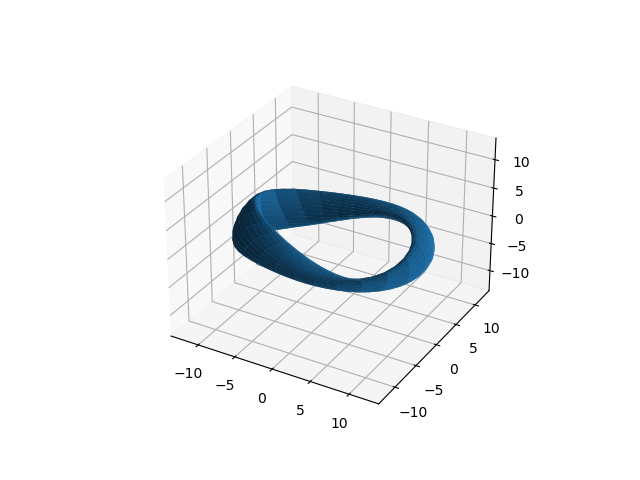

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf.plot(ax=ax, close=True)
for c in full_curves:
    c.plot(ax=ax, show=False)

In [11]:
for c in base_curves:
    c.fix_all()

In [12]:
sqflux = SquaredFlux( surf, bs )
lengths = QuadraticPenalty( sum([CurveLength(curve) for curve in base_curves]), Length, f='max' ) 
#lengths = [QuadraticPenalty( CurveLength(curve) , Length, f='max' ) for curve in base_curves]
cc_penalty = CurveCurveDistance( full_curves, CC_dist, len(full_curves) )
cs_penalty = CurveSurfaceDistance( base_curves, surf, CS_dist )
Jcs = [LpCurveCurvature(c, 2, kmax) for c in base_curves]


JF = 1e2*sqflux + wl * np.sum(lengths) + wcc*cc_penalty + wcs*cs_penalty + wk * np.sum(Jcs)

In [13]:
print(f'Original squared flux penalty is {sqflux.J()}')
#print(f'Max length is {Length}, starting length is {lengths.J()}')
print(f'Min coil-coil distance is {CC_dist}, starting minimum distance is {cc_penalty.shortest_distance()}')
print(f'Min plasma-coil distance is {CS_dist}, starting minimum distance is {cs_penalty.shortest_distance()}')
print(f'Original target function is {JF.J()}')

Original squared flux penalty is 0.07240964158146997
Min coil-coil distance is 0.9959999999999999, starting minimum distance is 1.2166079877738434
Min plasma-coil distance is 1.5, starting minimum distance is 1.050611985421265
Original target function is 8.858892003183797


In [14]:
surf.fix_all()

for current in base_currents:
    current.unfix_all()
base_currents[0].fix_all()

for c in base_curves:
    c.unfix_all()

def fun(x, info):
    JF.x = x
    info['Nfeval'] += 1
    J = JF.J()
    dJ = JF.dJ()
    if np.mod(info['Nfeval'],10)==0:
        nf = info['Nfeval']
        print(f'Evaluation #{nf}: J={J}, max(|dJ|)={np.max(np.abs(dJ))}')
    return J, dJ

In [15]:

    
options={'maxiter': 1000, 'maxcor': 300}
dofs = JF.x
res = minimize(fun, dofs, jac=True, method='L-BFGS-B', args=({'Nfeval':0}), options=options, tol=1e-12)
print(res.message)
print(f'Optimized squared flux penalty is {sqflux.J()}')
#print(f'Max length is {Length}, optimized length is {lengths.J()}')
print(f'Min coil-coil distance is {CC_dist}, optimized minimum distance is {cc_penalty.shortest_distance()}')
print(f'Min plasma-coil distance is {CS_dist}, optimized minimum distance is {cs_penalty.shortest_distance()}')
print(f'Final target function is {JF.J()}')
print(f'============================================\n\n')

OPTIMIZATION FOR ORDER=1

Evaluation #10: J=5.975012492152264, max(|dJ|)=16.076420779952585
Evaluation #20: J=0.6571431976326912, max(|dJ|)=0.06962991640929216
Evaluation #30: J=0.6285489868367792, max(|dJ|)=0.17330400027783666
Evaluation #40: J=0.6178469754970937, max(|dJ|)=0.044943456449017725
Evaluation #50: J=0.7544621181472548, max(|dJ|)=1.386641843508403
Evaluation #60: J=0.6043095858972432, max(|dJ|)=0.011859985288047558
Evaluation #70: J=0.6035050289659515, max(|dJ|)=0.008090808509241768
Evaluation #80: J=0.6011924069476715, max(|dJ|)=0.03341906591800083
Evaluation #90: J=0.5998437506800642, max(|dJ|)=0.004842149000054136
Evaluation #100: J=0.5992814645428479, max(|dJ|)=0.005613615993058273
Evaluation #110: J=0.5986756683629093, max(|dJ|)=0.02236601275953168
Evaluation #120: J=1.2187483350221529, max(|dJ|)=3.9174865220624424
Evaluation #130: J=0.5983128768071392, max(|dJ|)=0.024293004318764144
Evaluation #140: J=0.5977693973636308, max(|dJ|)=0.00691556569744373
Evaluation #150:

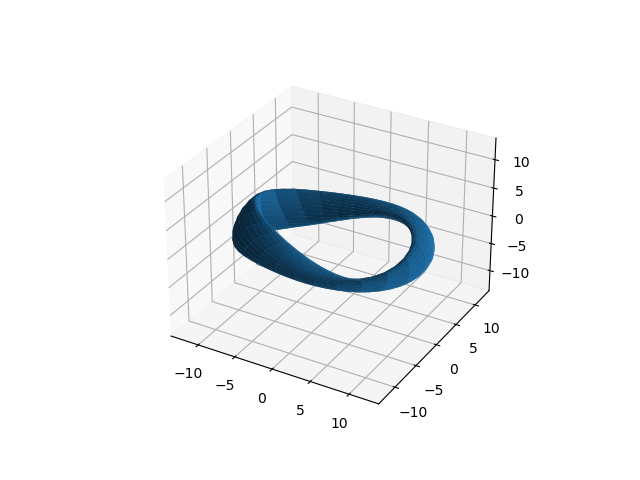

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf.plot(ax=ax, close=True)
for c in full_curves:
    c.plot(ax=ax, show=False)

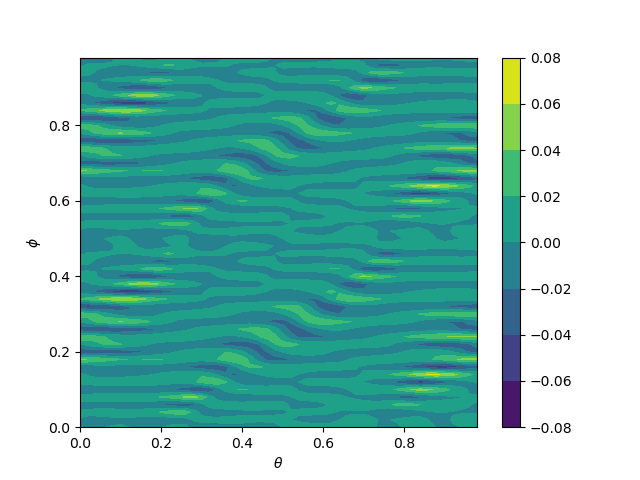

In [18]:
fig, ax = plt.subplots()
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(surf.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2) / bs.AbsB().reshape((nphi,ntheta))
modb = np.mean(bs.AbsB())


#ax.set_title(f'B normal from coils {indices}')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')
c = ax.contourf(theta,phi,Bdotn/modb)
#c = ax.contourf(theta,phi,Bdotn+np.flip(np.flip(Bdotn,axis=1),axis=0))
plt.colorbar(c)

In [18]:
np.mean(bs.AbsB())

0.13993921100174203

In [19]:
from pystellplot.Paraview import coils_to_vtk, surf_to_vtk
from simsopt.field import compute_fieldlines, LevelsetStoppingCriterion, SurfaceClassifier, plot_poincare_data
import os

In [20]:
coils_to_vtk( coils, os.path.join('coils', f'coils.ncoil={ncoils}_nwp={nwp}' ) )
surf_to_vtk( os.path.join('surf', f'surf.ncoil={ncoils}_nwp={nwp}'), bs, surf )

In [21]:
vmec_surf_1 = SurfaceRZFourier.from_wout('wout_landreman_paul_qa_scaled.nc') # Expanded vmec surface
vmec_surf_1.extend_via_normal(0.1)

In [24]:
nfieldlines = 10
tmax_fl = 20000
degree = 4
Rmaj = v.boundary.major_radius()
r0 = v.boundary.minor_radius()

def trace_fieldlines(bfield):
    # Set up initial conditions - 
    R0 = np.linspace(11, 12, nfieldlines)
    Z0 = np.zeros(nfieldlines)
    phis = [(i/4)*(2*np.pi/nfp) for i in range(4)]
    fieldlines_tys, fieldlines_phi_hits = compute_fieldlines(
        bfield, R0, Z0, tmax=tmax_fl, tol=1e-8,
        phis=phis, stopping_criteria=[])

    plot_poincare_data(
        fieldlines_phi_hits, phis, 
        'poincare_fieldline.png', 
        dpi=150,surf=v.boundary,mark_lost=False
    )
    return fieldlines_phi_hits

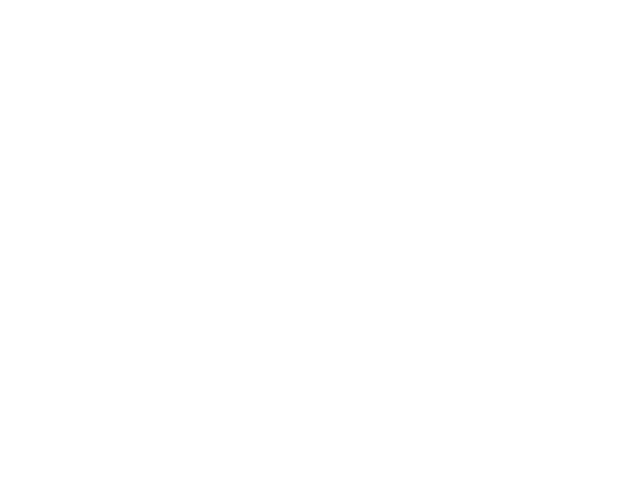

In [25]:
hits = trace_fieldlines(bs)